In [182]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [183]:
class ActionSpace():
    """Abstract model for a space that is used for the state and action spaces. This class has the
    exact same API that OpenAI Gym uses so that integrating with it is trivial.
    Please refer to [Gym Documentation](https://gym.openai.com/docs/#spaces)
    """
    def __init__(self):
        self.actions = [(0, 0), (0, 1), (1, 0), (1, 1)]
    
    def sample(self, seed=None):
        if seed is not None:
            return self.actions[np.random.RandomState(seed=seed).randint(low=0, high=len(self.actions))]
        return self.actions[np.random.randint(low=0, high=len(self.actions))]

    def contains(self, x):
        """Return boolean specifying if x is a valid member of this space
        """
        return True if x in self.actions else False

In [184]:
class StateSpace():
    """Abstract model for a space that is used for the state and action spaces. This class has the
    exact same API that OpenAI Gym uses so that integrating with it is trivial.
    Please refer to [Gym Documentation](https://gym.openai.com/docs/#spaces)
    """
    def __init__(self):
        self.states = [(i, j) for j in range(1, 9) for i in range(1, 9)] ## Some are non reachable
    
    def sample(self, seed=None):
        if seed is not None:
            return np.random.RandomState(seed=seed).choice(self.states)
        return np.random.choice(self.states)

    def contains(self, x):
        """Return boolean specifying if x is a valid member of this space
        """
        return True if x in self.states else False

In [185]:
def get_max_indices(br):
    if br[0] > br[1]:
        br = set([0])
    elif br[0] < br[1]:
        br = set([1])
    else:
        br = set([0, 1])
    return br

In [186]:
def nash_equilibrium(bimatrix, return_all=False, choice="value"):
    assert(bimatrix.shape == (2, 2, 2))
    br = [[0, 0], [0, 0]]
    br[0][0] = get_max_indices(bimatrix[:, 0, 0])
    br[0][1] = get_max_indices(bimatrix[:, 1, 0])
    br[1][0] = get_max_indices(bimatrix[0, :, 1])
    br[1][1] = get_max_indices(bimatrix[1, :, 1])
    ne = []
    for s in [[0, 0], [0, 1], [1, 0], [1, 1]]:
        if s[0] in br[0][s[1]] and s[1] in br[1][s[0]]:
            ne.append(s)
    
    ## NE exists
    if len(ne) > 0:
        ## Multiple NE
        if len(ne) > 1:
            if not return_all:
                if choice == "value":
                    idx = -1
                    value = -10000000
                    for i in range(len(ne)):
                        if sum(bimatrix[ne[i][0], ne[i][1]]) > value:
                            value = sum(bimatrix[ne[i][0], ne[i][1]])
                            idx = i
                    return [ne[idx][0], ne[idx][1]], bimatrix[ne[idx][0], ne[idx][1]]
                ## Random choice
                else:
                    idx = np.random.randint(low=0, high=len(ne))
                    return [ne[idx][0], ne[idx][1]], bimatrix[ne[idx][0], ne[idx][1]]
            if return_all:
                _all = []
                for i in range(len(ne)):
                     _all.append([[ne[i][0], ne[i][1]], bimatrix[ne[i][0], ne[i][1]]])
                return _all
        else:
            idx = 0
            return [ne[idx][0], ne[idx][1]], bimatrix[ne[idx][0], ne[idx][1]]
    return None

In [224]:
class Enviroment():
    
    def __init__(self):
        #reward_range = (-np.inf, np.inf)
        self.action_space = ActionSpace()
        self.state_space = StateSpace() # state_space
        self.q_table = {}
        for st in self.state_space.states:
            self.q_table[st] = np.array([[[0, 0], [0, 0]], [[0, 0], [0, 0]]], dtype=np.float32)
        self.info = {}
        self.t = 0
        self.start_state = (1, 2)
        self.current_state = (1, 2)
        self._seed = None
        self.agent_A_pos = (0.25,0.5)
        self.agent_B_pos = (2.75,0.5)
        self.status = 'train'
    
    def set_status(self,status):
        self.status = status
    
    def _next_state_A(self, state_A, action_A):
        up = {1:3, 3:6, 6:6, 4:7, 7:7, 2:5, 5:8, 8:8}
        right = {1:4, 3:4, 6:7, 4:5, 7:8, 2:8, 5:8, 8:8}
        if action_A == 1:
            return up[state_A]  
        else:
            return right[state_A]
    
    def _next_state_B(self, state_B, action_B):
        up = {1:3, 3:6, 6:6, 4:7, 7:7, 2:5, 5:8, 8:8}
        left = {1:1, 3:3, 6:6, 4:3, 7:6, 2:4, 5:4, 8:7}
        if action_B == 1:
            return up[state_B]  
        else:
            return left[state_B]
    
    def _is_final_state(self, new_state):
        assert(self.state_space.contains(new_state))
        ## Co operation: All 3 ways
        if new_state[0] == 7 and new_state[1] == 7:
            return True
        
        ## Fight!: All 2 ways
        if new_state[0] == 4 and new_state[1] == 4:
            return True
        
        ## A hunts B: Just one way this happens: Sightly tricky
        if new_state[0] == 7 and new_state[1] != 7:
            return True
        
        ## B hunts A: Just one way this happens: Slightly tricy
        if new_state[0] != 7 and new_state[1] == 7:
            return True
        
        return False
        
    def _reward(self, new_state):
        assert(self.state_space.contains(new_state))
        ## Co operation
        if new_state[0] == 7 and new_state[1] == 7:
            return (3, 3)
        
        if new_state[0] == 4 and new_state[1] == 4:
            return (-1, -1)
        
        if new_state[0] == 7 and new_state[1] != 7:
            return (2, 0)
        
        if new_state[0] != 7 and new_state[1] == 7:
            return (0, 2)
        return (0, 0)
    
    def make_grid(self):
        x = np.arange(0, 4, 1)
        y = np.arange(0, 4, 1)
        
        fig = plt.figure()
        ax = fig.gca()
        ax.set_xticks(np.arange(0, 4, 1))
        ax.set_yticks(np.arange(0, 4, 1))
        plt.grid()
        agent_A = plt.Circle(self.agent_A_pos,0.1,color='r')
        agent_B = plt.Circle(self.agent_B_pos,0.1,color='b')
        prey = plt.Circle((1.5,2.5),0.1,color='g')
        ax.add_artist(agent_A)
        ax.add_artist(agent_B)
        ax.add_artist(prey)
        plt.show()
    
    def change_pos(self,action):
        #For Agent A
        if(self.current_state[0]==1 and action[0]==0):
            self.agent_A_pos = (self.agent_A_pos[0]+1,self.agent_A_pos[1]+1)
        elif(self.current_state[0]==6 and action[0]==1):
            self.agent_A_pos = (self.agent_A_pos[0],self.agent_A_pos[1])
        else :
            if(action[0]==0): #if Left
                self.agent_A_pos = (self.agent_A_pos[0]+1,self.agent_A_pos[1])
            elif(action[0]==1): # If up
                self.agent_A_pos = (self.agent_A_pos[0],self.agent_A_pos[1]+1)
        
        # For Agent B
        if(self.current_state[1]==2 and action[1]==0):
            self.agent_B_pos = (self.agent_B_pos[0]-1,self.agent_B_pos[1]+1)
        elif (self.current_state[1]==8 and action[1]==1):
            self.agent_B_pos = (self.agent_B_pos[0],self.agent_B_pos[1])
            
        else:    
            if(action[1]==0):
                self.agent_B_pos = (self.agent_B_pos[0]-1,self.agent_B_pos[1])
            elif(action[1]==1):
                self.agent_B_pos = (self.agent_B_pos[0],self.agent_B_pos[1]+1)
    
    def step(self, action):
        """Run one timestep of the environment's dynamics.
        Accepts an action and returns a tuple (observation, reward, done, info).
        # Arguments
            action (object): An action provided by the environment.
        # Returns
            observation (object): Agent's observation of the current environment.
            reward (float) : Amount of reward returned after previous action.
            done (boolean): Whether the episode has ended, in which case further step() calls will return undefined results.
            info (dict): Contains auxiliary diagnostic information (helpful for debugging, and sometimes learning).
        """
        self.change_pos(action)
        self.render()
        new_state = (self._next_state_A(self.current_state[0], action[0]),\
                     self._next_state_B(self.current_state[1], action[1]))
        done = self._is_final_state(new_state)
        reward = self._reward(new_state)
        self.t += 1
        self.info[self.t] = (new_state, reward, done)
        self.current_state = new_state
        return new_state, reward, done, self.info[self.t]

    def reset(self):
        """
        Resets the state of the environment and returns an initial observation.
        # Returns
            observation (object): The initial observation of the space. Initial reward is assumed to be 0.
        """
        self.agent_A_pos = (0.25,0.5)
        self.agent_B_pos = (2.75,0.5)
        self.render()
        self.t = 0
        self.current_state = self.start_state
        return self.current_state

    def render(self, mode='human', close=False):
        """Renders the environment.
        The set of supported modes varies per environment. (And some
        environments do not support rendering at all.)
        # Arguments
            mode (str): The mode to render with.
            close (bool): Close all open renderings.
        """
        if(self.status =='train'):
            pass
        elif(self.status =='gui'):
            self.make_grid()

    def close(self):
        """Override in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        raise NotImplementedError()

    def seed(self, seed=None):
        """Sets the seed for this env's random number generator(s).
        # Returns
            Returns the list of seeds used in this env's random number generators
        """
        _seed = seed
        return _seed

    def configure(self, *args, **kwargs):
        """Provides runtime configuration to the environment.
        This configuration should consist of data that tells your
        environment how to run (such as an address of a remote server,
        or path to your ImageNet data). It should not affect the
        semantics of the environment.
        """
        raise NotImplementedError()

    #def __del__(self):
    #    self.close()

    def __str__(self):
        return '<{} instance>'.format(type(self).__name__)

In [225]:
alpha = 0.3
discount_rate = 1
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

In [226]:
env = Enviroment()
q_table = env.q_table
env.set_status('train')

In [227]:
num_episodes = 10000
max_steps_per_episode = 5
for episode in range(num_episodes):
    state = env.reset()
    for step in range(max_steps_per_episode):
        r = np.random.uniform(0, 1)
        ## Exploitation
        if r > exploration_rate:
            ne = nash_equilibrium(q_table[state], choice="random")
            if ne is None:
                print('Ugh')
                break
            action = ne[0]
        ## Exploration
        else:
            action = env.action_space.sample(seed=env._seed)
            #print(action, end=" ")
        new_state, reward, done, info = env.step(action)
        
        #print(new_state, reward, done)
        ne = nash_equilibrium(q_table[new_state], choice="random")
        if ne is None:
            print('Ugh')
            break
        values = ne[1]
        update = (1 - alpha) * q_table[state][action[0]][action[1]] + \
                        alpha * (reward + discount_rate * values)
        q_table[state][action[0]][action[1]][0] = update[0]
        q_table[state][action[0]][action[1]][1] = update[1]
        state = new_state
        if done == True:
            break
    exploration_rate = min_exploration_rate + \
            (max_exploration_rate - min_exploration_rate)*np.exp(-exploration_decay_rate*episode) 
    #print()

In [228]:
nash_equilibrium(q_table[(1, 2)], return_all=True)

([1, 1], array([3., 3.], dtype=float32))

In [229]:
nash_equilibrium(q_table[(3, 5)], return_all=True)

[[[0, 1], array([3., 3.], dtype=float32)],
 [[1, 0], array([3., 3.], dtype=float32)],
 [[1, 1], array([3., 3.], dtype=float32)]]

In [230]:
q_table[(3, 5)]

array([[[-0.99999994, -0.99999994],
        [ 3.        ,  3.        ]],

       [[ 3.        ,  3.        ],
        [ 3.        ,  3.        ]]], dtype=float32)

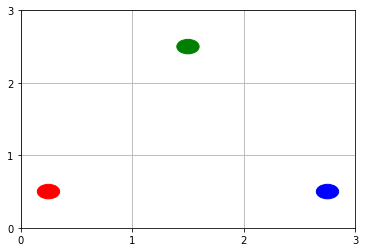

[1, 1]


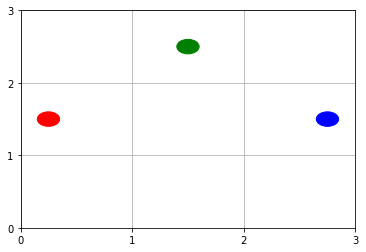

[1, 1]


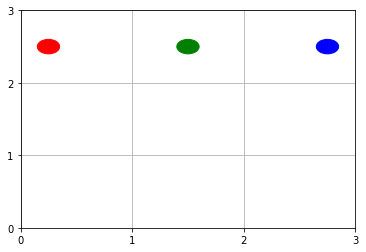

[0, 0]


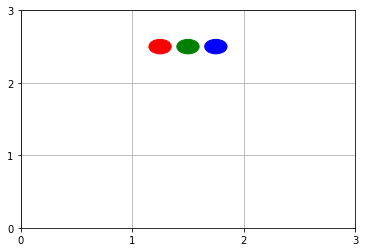

In [231]:
env.set_status('gui')
state = env.reset()
for step in range(max_steps_per_episode):
    ne = nash_equilibrium(q_table[state], choice="random")
    if ne is None:
        print('Ugh')
        break
    action = ne[0]
    print(action)
    new_state, reward, done, info = env.step(action)
    state = new_state
    if done == True:
        break